In [ ]:
import os
import sys
import numpy as np
from numpy import array
import random
import pandas as pd
# timer
import time
import pickle
import shutil

In [ ]:
# time-series statistical models

try:
    from statsmodels.tsa.arima.model   import ARIMA
except ModuleNotFoundError:
    !pip install statsmodels
    from statsmodels.tsa.arima.model   import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

    ############################################################################
### TensorFlow library
import tensorflow
      ######## GPU activation ###########
device_name = tensorflow.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))
    ############################################################################

      # Keras is the high-level API of the TensorFlow platform
import keras
from   keras.models     import Sequential
from   keras.layers     import Input, Dense, Dropout, LeakyReLU, PReLU
from   keras.optimizers import Adam, RMSprop, SGD
keras.optimizers.Adam(
     beta_1=0.9, beta_2=0.999,
     epsilon=1e-07)
keras.optimizers.SGD(
    momentum=0.0)
keras.optimizers.RMSprop(
     rho=0.9,
    momentum=0.0,
    epsilon=1e-07)

from keras.callbacks import EarlyStopping

try:
    import keras_tuner as kt
except ModuleNotFoundError:
    !pip install keras-tuner
    import keras_tuner as kt

from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
      # hide warnings from TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore', '.do not.', )
warnings.warn('Do not show this message')

Found GPU at: /device:GPU:0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


<ipython-input-2-f3c6132932ab>:53: UserWarning: Do not show this message
  warnings.warn('Do not show this message')


In [ ]:
# Plotting and warnings
import matplotlib.pyplot as plt  # data plotting
from   matplotlib import rcParams
rcParams['figure.figsize']     = [18,9]
rcParams['lines.markersize']   = 12         # marker size in points
rcParams['axes.labelsize']     = 15
rcParams['axes.titlesize']     = 12
rcParams['figure.dpi']         = 120
# for plotting and styling
import seaborn as sns
sns.set(context="notebook", palette="deep",
        style = 'darkgrid' ,font_scale = .9, color_codes=True)

# Visualize the training dataset
kolor = ['#78C850',  # Grass
          '#F08030',  # Fire
          '#6890F0',  # Water
          '#A8B820',  # Bug
          '#A8A878',  # Normal
          '#A040A0',  # Poison
          '#F8D030',  # Electric
          '#E0C068',  # Ground
          '#EE99AC',  # Fairy
          '#C03028',  # Fighting
          '#F85888',  # Psychic
          '#B8A038',  # Rock
          '#705898',  # Ghost
          '#98D8D8',  # Ice
          '#7038F8',  # Dragon
         ]

> Setting up the Keras Tuner

In [ ]:
# MLP Custom Model
def build_model(hp):
    #  Model-Building Function
    n_samples =  data_r['Nsamples']
    input_shape = round(np.log2(n_samples))-1
    ############################################################################
    hp_activ = hp.Choice('activation', data_r['f_activ'])
    hp_loss = hp.Choice('Loss',data_r['LossSet'])
    hp_opt = hp.Choice('optimizer', data_r['OptSet'])
    ############################################################################

    model = Sequential()
    model.add(Input(shape = input_shape )) #????

    for l in range(hp.Int('num_layers',1,4)):
      # Tune the number of units in each l dense layer
      model.add(Dense(units=hp.Int(f'units1_{l}', min_value=int(n_samples/15),
                max_value=int(n_samples/3), step=int(n_samples/15)),
                      #activation = hp_activ,
                      activation = hp.Choice(f'activation_{l}', data_r['f_activ']),
                     kernel_initializer='he_uniform'))
      # tune the dropout value in each l lalyer
      model.add(Dropout(rate = hp.Float(f'dropout_{l}',
                                            min_value=0, max_value=0.5, step=.1)))

    model.add(Dense(1, activation=hp_activ))

    # Tune the learning rate for the optimizer
    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(optimizer = hp_opt,
                loss = hp.Choice('Loss',data_r['LossSet']),
                metrics=['MeanSquaredError'])
    return model

> Data creation

In [ ]:
# time-series models

def timeseries(n_samples,process:int)-> np.ndarray:
    np.random.seed(np.random.randint(low = 0, high = 99, size = 1))
    if process == 1:
        # random walk
        AR_μ = RandomWalk(64,n_samples)
        lab ='random walk'
        # ARMA  models
    elif process == 2:
        # ARMA(3, 3) model
        # alphas = array([-.933, 0.003, -0.003]) ; betas  = array([ .01, -.001, 0.001])
        alphas = array([-random.randint(840, 960)/1000, -random.randint(1, 9)/1000, --random.randint(1, 9)/1000]) #
        betas  = array([ random.randint(5, 15)/1000, -random.randint(5, 15)/10000, random.randint(5, 15)/10000])
        lab ='rARMA(3, 3)'
    elif process == 3:
        # ARMA(2, 2) model
        alphas = np.array([-0.03, 0.03])
        betas  = np.array([0.93, -0.33])
        lab ='rARMA(2, 2)'
    if process != 1:
        α = np.r_[1, alphas]; β = np.r_[1, betas]
        AR_μ = ArmaProcess(α, β).generate_sample(n_samples)
    return normalize_max_min(AR_μ),lab

# Random walk
def RandomWalk(NStates,n_samples:int)-> np.ndarray:
    # Probability to move up or down
    prob = [0.5, 0.5]
    # Testing values
    # [0.005, 0.995]  [0.05, 0.95]  [0.25, 0.75]  [0.5, 0.5]  [0.995, 0.005]
    # Starting position
    start = np.random.randint(low = 0, high = NStates-1, size = 1)
    positions = [start]
    # creating the random points
    Npoints = n_samples           # Sequence length
    rr = np.random.random(Npoints)
    downp = rr < prob[0]
    upp = rr > prob[1]
    for idownp,iupp in zip(downp,upp):
        down = idownp and positions[-1] > 1
        up   = iupp   and positions[-1] < NStates
        positions.append(positions[-1]  - down + up)
    return normalize_max_min(positions)

In [ ]:
# split a univariate sequence into timesteps
def data_sequencing(dataset,partition,step_back):
    train_size = int(len(dataset) * partition)
    train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]

    for i in ['training','test']:
        X, y = list(), list()
        if i == 'training':
            t0 = len(train_dataset); window = train_dataset
        if i == 'test':
            t0 = len(test_dataset) ; window = test_dataset
        for t in range(t0):
            # find the end of this pattern
            t_w = t + step_back
		        # check if we are beyond the sequence
            if t_w > t0-1:
              break
		        # gather input and output parts of the pattern
            seq_x, seq_y = window[t:t_w], window[t_w]
            X.append(seq_x)
            y.append(seq_y)
        if i == 'training':
            X_train = array(X); y_train = array(y);
        if i == 'test':
            X_test = array(X); y_test = array(y);
    return X_train,y_train,X_test,y_test

In [ ]:
def trainingData(process):
    #  dataset suitable for training an MLP model,
    # with a specified number of time steps (n_steps).
    n_samples = data_r['Nsamples']
          # Simulate a process
    dataset,_ = timeseries(n_samples,process)
          # training partition
    n_steps   = int(np.log2(n_samples/2))
          # split into train and test sets
    X_train,y_train,X_test,y_test = data_sequencing(dataset,data_r['partition'],n_steps)
    X_train = X_train.astype('float32'); X_test = X_test.astype('float32')
    y_train = y_train.astype('float32'); y_test = y_test.astype('float32')
    return X_train,y_train,X_test,y_test

In [ ]:
# pair wise linear relationship
def pairwise_correlation(A, B):
    am = A - np.mean(A, axis=0, keepdims=True)
    bm = B - np.mean(B, axis=0, keepdims=True)
    return am.T @ bm /  (np.sqrt(
        np.sum(am**2, axis=0,
               keepdims=True)).T * np.sqrt(
        np.sum(bm**2, axis=0, keepdims=True)))

In [ ]:
# data normalization [0,1]
def normalize_max_min(ξ: np.ndarray) -> np.ndarray:
    """
    Normalize a NumPy array to the range [0, 1].

    Parameters
    ----------
    ξ : np.ndarray
        Input NumPy array to be normalized.

    Returns
    -------
    np.ndarray
        Normalized array.
    """
    min_value = np.min(ξ)
    max_value = np.max(ξ)

    return (ξ - min_value) / (max_value - min_value)

> Main

In [ ]:
# Hyperparameter Space Definition
data_w = {
    'Nsamples':  4096,
    #2048 # 1024 # 512 #128 #  4096 # 256 #
    'partition': 0.67,

    ############################################################################
    # Input tuning parameters
          # activation function set
    'f_activ': ['linear', 'tanh','relu', 'LeakyReLU',  'elu', 'PReLU', 'swish'],
          # Optimizing algorithms
    'OptSet': ['adam', 'sgd', 'rmsprop'],
          # Training model with objectives
    'LossSet': ['mean_squared_error','mean_squared_logarithmic_error'],
          # Optimizing algorithms
    'OptTun_Set': ['RandomSearch','Hyperband','Bayesian'],
    # output tuning parameters
    'epochs': 32,
    'max_iter': 6}
    ############################################################################

pickle.dump(data_w, open('filename.pkl', 'wb'))
data_r = pickle.load(open('filename.pkl', 'rb'))

X_train,y_train,X_test,y_test = trainingData(2)

best values hpRandomSearch  {'activation': 'linear', 'Loss': 'mean_squared_error', 'optimizer': 'sgd', 'num_layers': 1, 'units1_0': 273, 'activation_0': 'LeakyReLU', 'dropout_0': 0.0, 'lr': 0.00030154797014856597, 'units1_1': 1365, 'activation_1': 'swish', 'dropout_1': 0.30000000000000004, 'units1_2': 273, 'activation_2': 'linear', 'dropout_2': 0.1, 'units1_3': 273, 'activation_3': 'swish', 'dropout_3': 0.4}
42/42 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Test loss ε[RandomSearch]: 0.0038677467964589596
ε[RandomSearch]  = 0.004739, ̂τ = 5.45
τ_tunner[RandomSearch] = 249.00
best values hpHyperband  {'activation': 'swish', 'Loss': 'mean_squared_logarithmic_error', 'optimizer': 'adam', 'num_layers': 1, 'units1_0': 1092, 'activation_0': 'linear', 'dropout_0': 0.0, 'lr': 0.007765767620141046, 'units1_1': 1092, 'activation_1': 'relu', 'dropout_1': 0.1, 'units1_2': 1092, 'activation_2': 'relu', 'dropout_2': 0.30000000000000004, 'units1_3': 546,

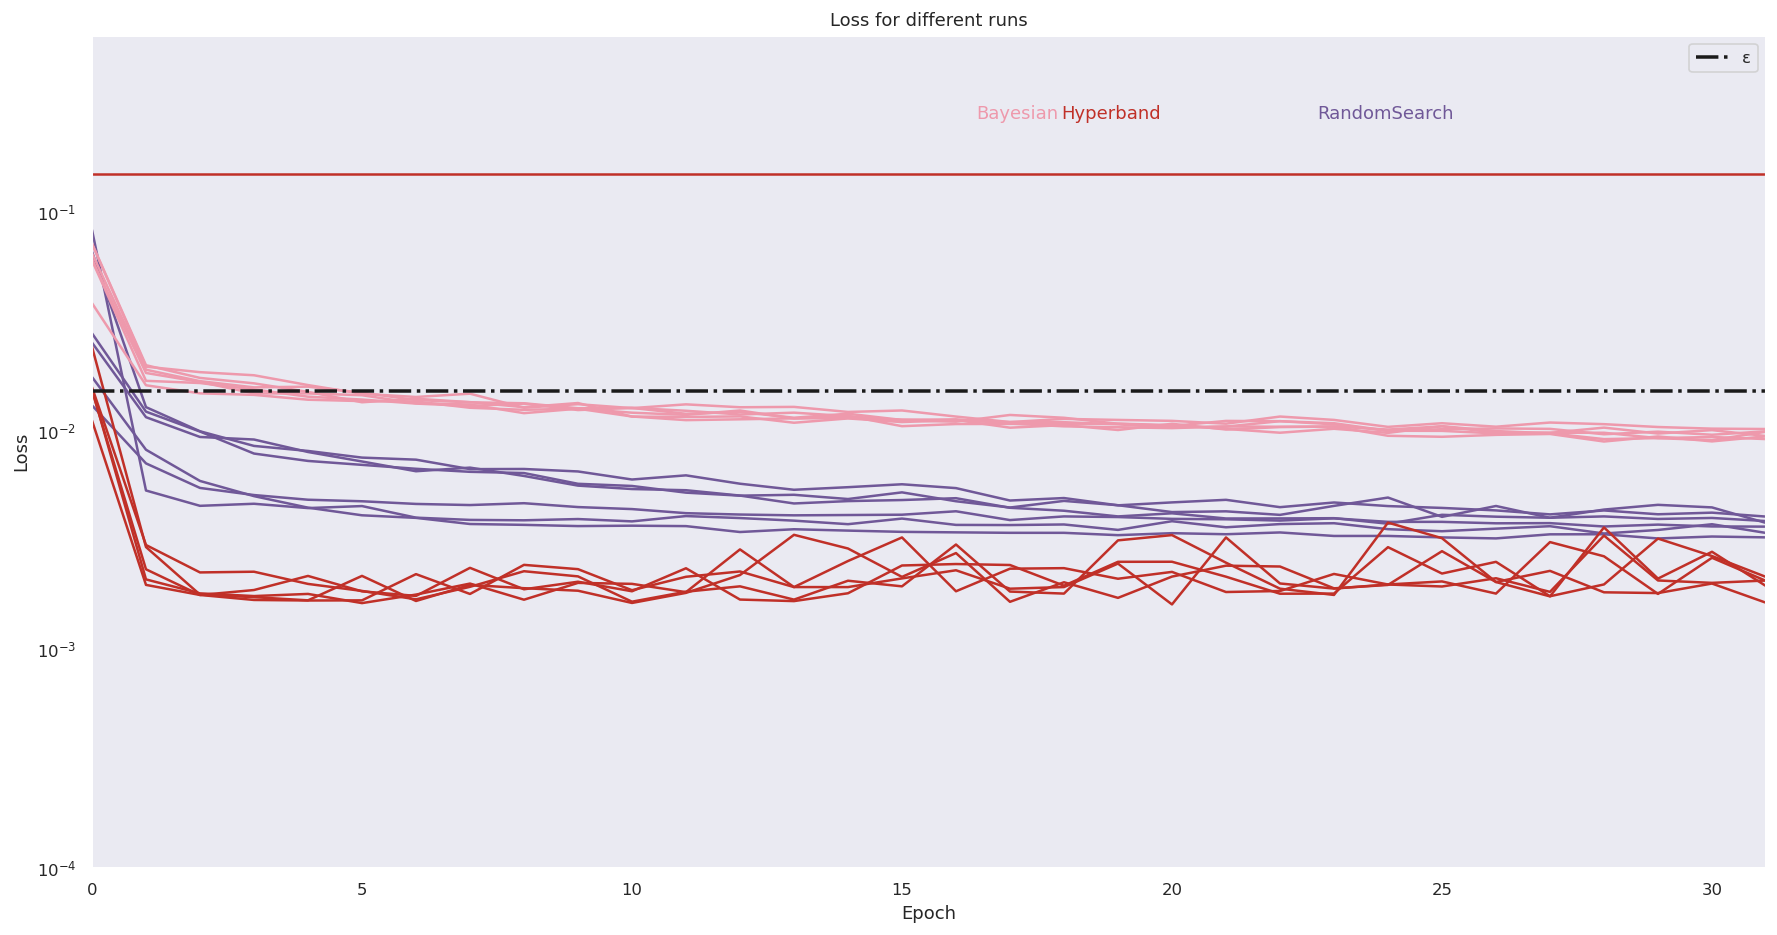

In [ ]:
import logging
import tensorflow as tf

# Configura el nivel de logging para ignorar warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

π = []; best_π = []
for i in (data_r['OptTun_Set']):
    start0  = time.time()
    if i == 'RandomSearch':
          # using the  Random Search algorithm
        tuner = kt.RandomSearch(
            hypermodel=build_model,
            objective= kt.Objective(data_r['LossSet'][0],direction='min'),#'val_loss',
            max_trials = 12,
            #  number of  model configurations (hyperparameter combinations) to test at most
            executions_per_trial = 3,
            # the number of times each set of hyperparameters to train and evaluate the model
            # for reducing the impact of randomness and ensure the robust results
            overwrite=True,
            directory="/content/"+i,
            # directory to save the results
            project_name="RS_Tune")
    if i == 'Hyperband':
        # using the Hyperband search algorithm
        tuner = kt.Hyperband(
            hypermodel = build_model,
            objective=data_r['LossSet'][0],
            max_epochs=9, # Maximum number of epochs to train each model
            hyperband_iterations = 2,
            factor=3,
            seed=42,  # Random seed for reproducibility
            directory="/content/"+i,
            project_name="Hyper_Tune")
    if i == 'Bayesian':
        tuner = kt.BayesianOptimization(
            hypermodel=build_model,
            objective=data_r['LossSet'][0],
            max_trials=9,
            executions_per_trial=2,
            directory="/content/"+i,
            project_name="Bayes_Tune")
    # Define a callback for early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=data_r['LossSet'][0],
        patience=9, #  the loss stops decreasing for a {patience} epochs
        mode='min',
        restore_best_weights=True)

    #tuner.search_space_summary()
    # Running the Tuner
    tuner.search(X_train,y_train, epochs = 5,#data_r['epochs'],
            validation_data=(X_test,y_test),callbacks=[early_stopping],
                 verbose=0)

    # Retrieving the Best Model sorted by loss
    best_models = tuner.get_best_models(num_models=1) # [0]??
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    #print(f"Optimal number of layers: {best_hp.get('num_layers')}")

    best_π.append(best_hp)

    # Build and train the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hp)
    print(f'best values hp{i} ',best_hp.values)

    #summary = tuner.results_summary(num_trials=10)
    # Evaluating the Best Model
    test_loss, _= best_models[0].evaluate(X_test, y_test)
    print(f'Test loss ε[{i}]:', test_loss)

    h = 0; Σ = [];
    while h < data_r['max_iter']:
        model = tuner.hypermodel.build(best_hp)
        start   = time.time()
        history = model.fit(X_test, y_test, epochs = data_r['epochs'],
                 #callbacks=[keras.callbacks.EarlyStopping()],
                  # callbacks for  saving the best model, adjusting the learning rate,
                  # or stopping training early if certain conditions are met.
                verbose=0)
        Σ.append(np.median(history.history['loss']))
        h = h + 1
        plt.semilogy(history.history['loss'], color=kolor[len(str(i))])
    π.append(np.median(Σ)+.5*np.std(Σ))
    print(f'ε[{i}]  = {np.median(Σ)+.5*np.std(Σ):.6f}, \u0302τ = {(time.time() - start):.2f}')
    print(f'τ_tunner[{i}] = {(time.time() - start0):.2f}')
    plt.text(.12+.051*len(str(i)), .9, f'{i}', color=kolor[len(str(i))], transform=plt.gca().transAxes)
    shutil.rmtree("/content/"+i)
y_ε = np.mean(π) ; miny =  max(y_ε-60*np.std(π),1e-4); maxy = y_ε+60*np.std(π)
plt.xlim(0,data_r['epochs']-1); plt.ylim(miny,maxy)
plt.title('Loss for different runs')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.axhline(y=y_ε, color='k', linestyle='-.',label ='ε',linewidth=2.1)
plt.legend(); plt.grid()
plt.savefig('run06.png')
plt.show()

min ε[ 1] Hyperband
{'activation': 'PReLU', 'Loss': 'mean_squared_error', 'optimizer': 'adam', 'num_layers': 4, 'units1_0': 1365, 'activation_0': 'swish', 'dropout_0': 0.0, 'lr': 0.0014517231809036133, 'units1_1': 819, 'activation_1': 'linear', 'dropout_1': 0.1, 'units1_2': 1365, 'activation_2': 'relu', 'dropout_2': 0.1, 'units1_3': 1092, 'activation_3': 'LeakyReLU', 'dropout_3': 0.0, 'tuner/epochs': 9, 'tuner/initial_epoch': 3, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0013'}


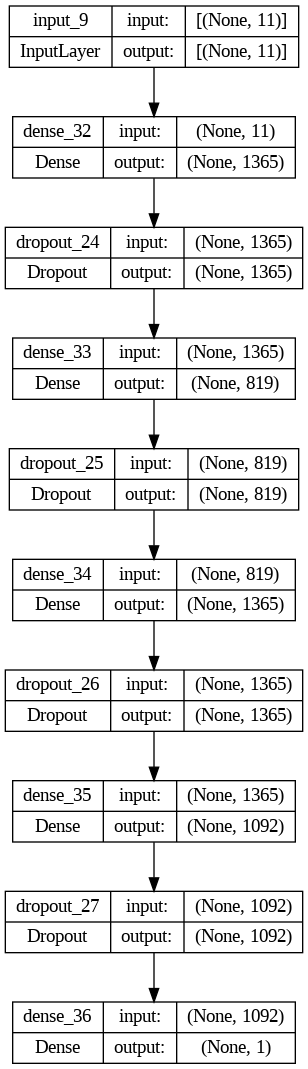

In [ ]:
print(f'min ε[ {np.argmin(π)}]', data_r['OptTun_Set'][np.argmin(π)])

# Build and train the model with the optimal hyperparameters
model_tuned = tuner.hypermodel.build(best_π[np.argmin(π)])
print(best_π[np.argmin(π)].values)
# display model structure
plot_model(model_tuned, 'best_model.png', show_shapes=True)

In [ ]:
b0 =  int(max(5,int(data_r['Nsamples']/24)))
batchSet  = [ int(.5*b0), int(.75*b0), b0, int(1.5*b0),  2*b0]

history_dict = {}; π = []
for n_batch in batchSet:
    start   = time.time()
    history = model_tuned.fit(X_train, y_train,  batch_size=n_batch,verbose= 0)
    history_dict[n_batch] = history
    ε  = np.median(history.history['loss'])+.5* np.std(history.history['loss']); π.append(ε)
    print(f'{n_batch} batch size,  τ = {time.time() - start:.1f}, ε  = {ε :.4f} ')
min_Batchs = np.argmin(π); print('best number of batchs: ', batchSet[min_Batchs],f'\nmin error {min(π)}')

85 batch size,  τ = 2.8, ε  = 29.0212 
127 batch size,  τ = 0.2, ε  = 0.0128 
170 batch size,  τ = 0.2, ε  = 0.0120 
255 batch size,  τ = 0.2, ε  = 0.0119 
340 batch size,  τ = 0.2, ε  = 0.0115 
best number of batchs:  340 
min error 0.011546355672180653


In [ ]:
history = model_tuned.fit(X_train, y_train,  batch_size=min_Batchs,verbose= 0)
# Evaluate the skill of the Trained model
trainPredict = np.array(model_tuned.predict(X_train))
trainPredict = np.reshape(trainPredict, (len(trainPredict), 1))
testPredict  = np.array(model_tuned.predict(X_test))
testPredict  = np.reshape(testPredict, (len(testPredict), 1))
#print(trainPredict.shape,testPredict.shape)


42/42 [==============================] - 0s 3ms/step


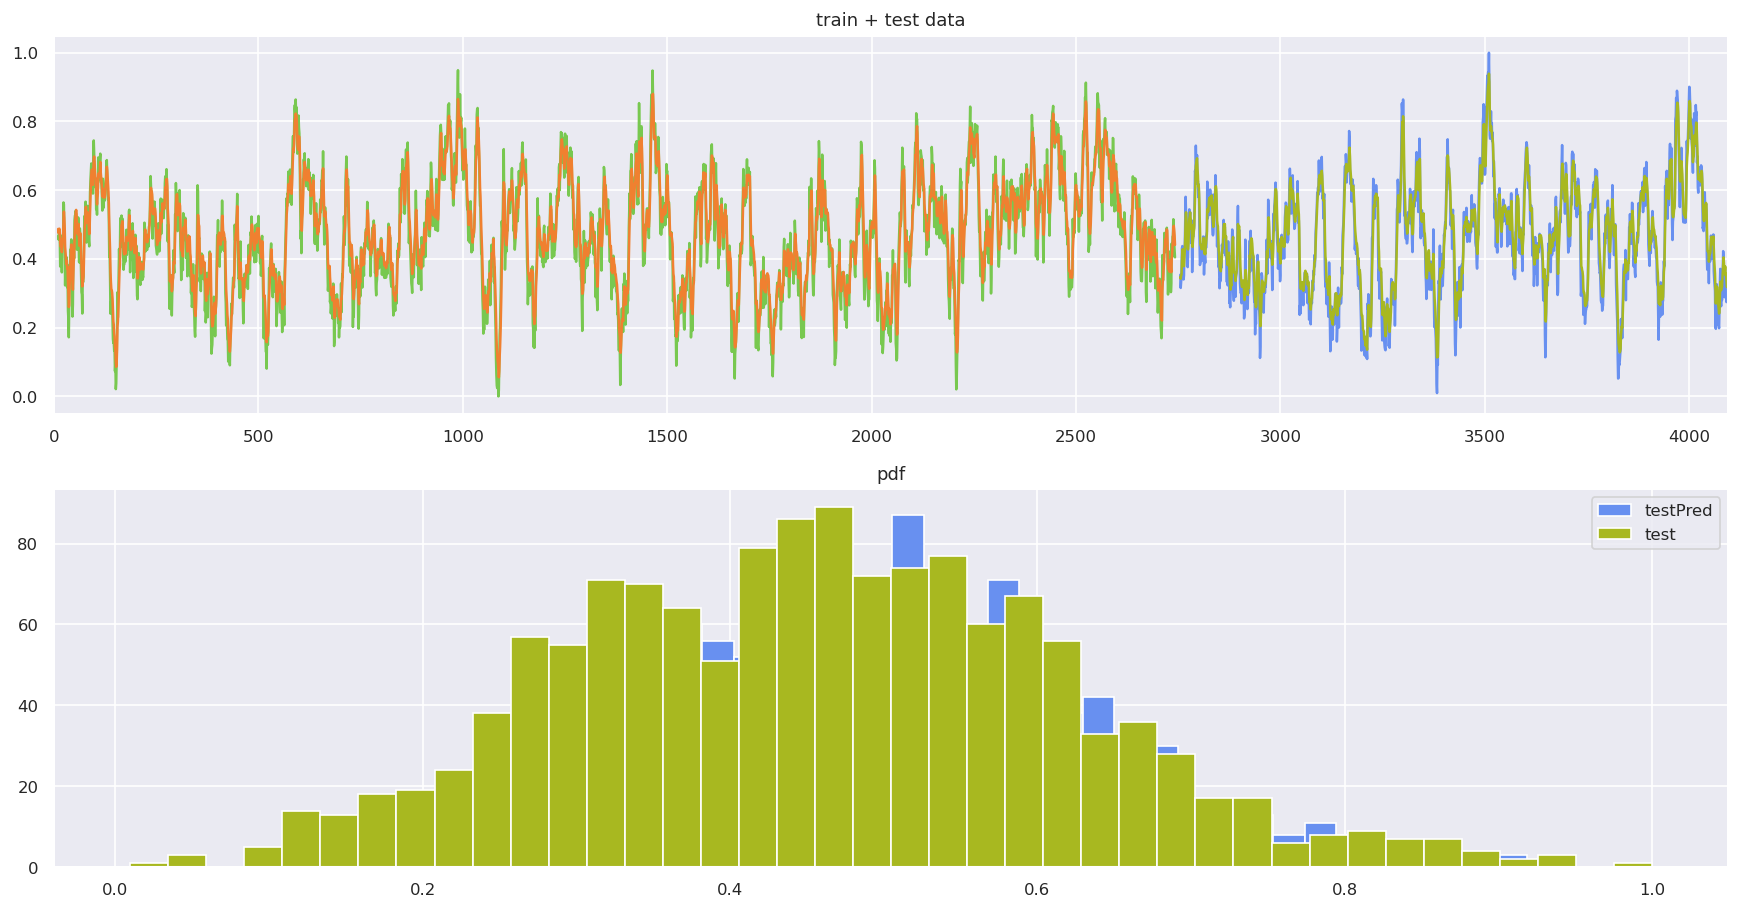

In [ ]:
# plot baseline and predictions
fig, axes = plt.subplots(2, 1)
shift = int(np.log2(data_r['Nsamples']/2))-1
axes[0].plot(range(shift, len(X_train[:,shift])+shift),X_train[:,shift], label = 'train ',color=kolor[0])
axes[0].plot(range(shift, len(trainPredict)+shift),trainPredict, label = 'train ',color=kolor[1])

axes[0].plot(range(data_r['Nsamples']-len(X_test[:,shift]), data_r['Nsamples']), X_test[:,shift], label = 'test',color=kolor[2])
axes[0].plot(range(data_r['Nsamples']-len(testPredict), data_r['Nsamples']), testPredict, label = 'test',color=kolor[3])
axes[0].set_xlim([0, data_r['Nsamples']-1])
axes[0].title.set_text('train + test data')
axes[1].title.set_text('pdf')
Nbins = int(1 + 3.322*np.log2(data_r['Nsamples']))
#axes[1].hist(trainPredict,bins=Nbins,label='trainPred')
axes[1].hist(testPredict, bins=Nbins,label='testPred',color=kolor[2])
#axes[1].hist(X_train[:,0],bins=Nbins,label='train')
axes[1].hist(X_test[:,0], bins=Nbins,label='test',color=kolor[3])
plt.legend()
plt.show()

https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203
https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/
https://haneulkim.medium.com/hyperparameter-tuning-with-keras-tuner-full-tutorial-f8128397e857
https://medium.com/@maslovavictoria/bayesian-hyperparameter-optimization-of-gradient-boosting-machine-6f51996ff5f1
https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-python-c581a129d4e4
https://medium.com/@redeaddiscolll/deep-learning-for-time-series-forecasting-of-stock-78e4abd6ae30#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjkzNGE1ODE2NDY4Yjk1NzAzOTUzZDE0ZTlmMTVkZjVkMDlhNDAxZTQiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTI2MTk3MDM0MzAyODM1MzE4NjMiLCJlbWFpbCI6ImdjYXN0ZWxsOUBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNzEyMzEwMDUxLCJuYW1lIjoiR2VybWFuIENhc3RlbGxhbm9zIERvbWluZ3VleiIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NMUGg5X21UM1RNYmZBWVd4Y2NIVElPTGRkQVpoSmR0MGY1eGpacENTYmR1QkhRMk00Qz1zOTYtYyIsImdpdmVuX25hbWUiOiJHZXJtYW4iLCJmYW1pbHlfbmFtZSI6IkNhc3RlbGxhbm9zIERvbWluZ3VleiIsImlhdCI6MTcxMjMxMDM1MSwiZXhwIjoxNzEyMzEzOTUxLCJqdGkiOiIwNjIxODZjNGQ5NDI3ZTBhMWRlZTFmMzgwYWJiY2QyZTU4NzVlOWM0In0.O_C0SI9o7yP8V7M16K7OHQspRpGsxW3LTFZ3_nVsD7kLG3iMFMVPwJkgI8-XojR8QL3LFqnlEg88j0ZPLqv_7Q6rFJ4Za5A3gYHh09Y8Mu24qBAi3ICZXgh2FE7W41WokL_CTzT02UmHDWSUzdXq14vLHRdhZcw2CCOEX6uZTsNeXK0eWeB2UkrxZmdzXpZZo-3aqEcDQ4JM7c_5InAmkDoS0-ycxMxCH4ZSLJnZWcoe0kLvDz7aieTiaHYI5mrLjJ773Xym7mzqswbhXuTAEeFxO_E2GYLng__ylPkI5JIYyV-NGbGwr0NKT-DnvTSdouFjfNzUqkbJDAvkXCt6vA
https://medium.com/@chenycy/accelerate-your-machine-learning-skills-with-hyperparameter-tuning-00dfd27e261c
https://towardsdatascience.com/tune-deep-neural-networks-using-bayesian-optimization-c9f6503a049f
https://gist.github.com/GermanCM/1943a0dc1eac04f848c6fe9b16947ac4
https://pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/
https://www.peterspython.com/es/blog/lstm-optimizacion-multipaso-hyperparameter-con-keras-tuner


